## An Experimental Study on Treap

This notebook documents an experimental comparison between Treap and Dynamic Array and their performance under different settings.  

This notebook implements:
* Data generator
* Sequence generator
* Randomised Treap
* Dynamic Array as a competitor 

This notebook conducts experiments under the following settings:
* Experiment 1: Time v.s. Number of Insertions
    * Sequence length $\in \{0.1M, 0.2M, 0.5M, 0.8M, 1M\}$, where $M$ = one million


* Experiment 2: Time v.s. Deletion Percentage.
    * Sequence length = $1M$
    * $prob_{delete} \in \{0.1\%, 0.5\%, 1\%, 5\%, 10\%\}, prob_{insert} = 1 - prob_{delete} $


* Experiment 3: Time v.s. Search Percentage.
    * Sequence length = $1M$
    * $prob_{search} \in \{0.1\%, 0.5\%, 1\%, 5\%, 10\%\}, prob_{insert} = 1 - prob_{search} $


* Experiment 4: Time v.s. Length of Mixed Operation Sequence
    * Sequence length $\in \{0.1M, 0.2M, 0.5M, 0.8M, 1M\}$, where $M$ = one million
    * $prob_{delete}=5\%, prob_{search}=5\%, prob_{insert}=90\%$

---

In [1]:
# lib for Data Generation and running Experiment
import numpy as np

# standard lib for evaluating performance
from time import time

# lib for presenting results
from pandas import DataFrame as DF
import matplotlib.pyplot as plt

In [2]:
# constants
SEED = 90077

# constants for Data Generator
KEY_LOWER = 0
KEY_UPPER = 10**7
DELETED = 0
LENGTH = 10**6

# constants for Sequence Generator
MIXED_PROBS = (0.9, 0.05, 0.05)

---
### Data Generator
#### Interfaces:
* gen_element()
* gen_insertion()
* gen_deletion()
* gen_search()

In [3]:
class Data_Generator():
    
    def __init__(self, size, seed=SEED):
        self.id = 1
        self.arr = np.empty(size+1, dtype=np.int32)
        self.rng = np.random.default_rng(seed=seed)
    def gen_element(self):
        id_ = self.id
        key = self.rng.integers(KEY_LOWER, KEY_UPPER, dtype=np.int32, endpoint=True)
        self.id += 1
        self.arr[id_] = key
        return id_, key
    
    def gen_insertion(self):
        return 1, self.gen_element()[1]
    
    def gen_deletion(self):
        if self.id == 1:
            return 2, self.rng.integers(KEY_LOWER, KEY_UPPER, dtype=np.int32, endpoint=True)
        id_del = self.rng.integers(1, self.id)
        if (key_del:=self.arr[id_del]) == DELETED:
            return 2, self.rng.integers(KEY_LOWER, KEY_UPPER, dtype=np.int32, endpoint=True)
        else:
            self.arr[id_del] = DELETED
            return 2, key_del
    
    def gen_search(self):
        return 3, self.rng.integers(KEY_LOWER, KEY_UPPER, dtype=np.int32, endpoint=True)

---
### Sequence Generator
**gen_sequence(seq_type, seed=SEED, length=LENGTH, prob=None)**
* @argument *seq_type* $\in$ $\{$insertion, deletion, search, mixed$\}$

In [4]:
def gen_sequence(seq_type, seed=SEED, length=LENGTH, prob=None):
    dg    = Data_Generator(length, seed)
    rng   = np.random.default_rng(seed=seed)
    seq   = np.empty(length, dtype="int8, int32")
    seq_type = seq_type[0]
    
    if seq_type == 'i':
        for i in range(length): seq[i] = dg.gen_insertion()
    elif seq_type == 'd':
        assert 0<prob<1
        ops = rng.choice(('i', 'd'), length, p=(1-prob, prob)) 
        for i, op in enumerate(ops):
            if op == 'i':   seq[i] = dg.gen_insertion()
            else:           seq[i] = dg.gen_deletion()
    elif seq_type == 's':
        assert 0<prob<1
        ops = rng.choice(('i', 'd'), length, p=(1-prob, prob)) 
        for i, op in enumerate(ops):
            if op == 'i':   seq[i] = dg.gen_insertion()
            else:           seq[i] = dg.gen_search()
    elif seq_type == 'm':
        ops = rng.choice(('i', 's', 'd'), length, p=MIXED_PROBS) 
        for i, op in enumerate(ops):
            if   op == 'i': seq[i] = dg.gen_insertion()
            elif op == 's': seq[i] = dg.gen_search()
            else:           seq[i] = dg.gen_deletion()
    return seq

**Sequence Applicator**

In [5]:
def run_sequence(seq, data_structure):
    t0 = time()
    ds = data_structure()
    insert = ds.insert
    delete = ds.delete
    search = ds.search
    for op, key in seq:
        if   op==1: insert(key)
        elif op==2: delete(key)
        elif op==3: search(key)
    return int(time()-t0)

---
### Treap
An implementation of Treap that supports the following operations:
* insert(key)
* delete(key)
* search(key)

In [6]:
class Treap():
    def __init__(self, seed=SEED):
        self.rng = np.random.default_rng(seed=seed)
        self.gen_priority = self.rng.random
        self.root = None
    
    def insert(self, key):
        if self.root is None:
            self.root = self.TreapNode(self.gen_priority(), key)
        else:
            self._insert(self.root, key)
    
    def _insert(self, node, key):
        if key < node.key:
            if node.L is not None:
                self._insert(node.L, key)
            else:
                node.L = self.TreapNode(self.gen_priority(), key, node)
                self._bubble_up(node.L)
        else:
            if node.R is not None:
                self._insert(node.R, key)
            else:
                node.R = self.TreapNode(self.gen_priority(), key, node)
                self._bubble_up(node.R)

    def _bubble_up(self, node):
        if (parent:=node.parent) is not None:
            if node.priority < parent.priority:
                if parent.L is node:
                    node.R, parent.L =\
                    parent, node.R, 
                    if parent.L:
                        parent.L.parent = parent
                else:
                    node.L, parent.R =\
                    parent, node.L, 
                    if parent.R:
                        parent.R.parent = parent
                if (grandparent:=parent.parent) is not None:
                    if grandparent.L is parent:
                        grandparent.L = node
                    else:
                        grandparent.R = node
                node.parent, parent.parent =\
                grandparent, node
                self._bubble_up(node)
        else:
            self.root = node
    
    def delete(self, key):
        node = self._search(key, self.root)
        # if it has at least one child
        if node is None:
            return
        if node.L is not None or node.R is not None:
            self._bubble_down(node)
        else:
            if self.root is node:
                self.root = None
                del node
            else:
                parent = node.parent
                if parent.L is node:
                    parent.L = None
                else:
                    parent.R = None
                del node
        
    def _bubble_down(self, node):
        # if it has two children
        if node.L and node.R:
            if node.L.priority < node.R.priority:
                new = node.L
                new.R, node.L =\
                node, new.R
                if node.L:
                    node.L.parent = node
            else:
                new = node.R
                new.L, node.R =\
                node, new.L
                if node.R:
                    node.R.parent = node
            if (parent:=node.parent) is not None:
                if parent.L is node:
                    parent.L = new
                else:
                    parent.R = new
            else:
                self.root = new
            new.parent, node.parent =\
            parent, new
            self._bubble_down(node)

        else:
            # if its parent is None, then it's root node
            if (parent:=node.parent) is None:
                if node.L is None:
                    self.root = node.R
                else:
                    self.root = node.L
                self.root.parent = None
                del node
            else:
                if node.L is None:
                    new = node.R
                elif node.R is None:
                    new = node.L
                else:
                    del node
                    return
                new.parent = parent
                if parent.L is node:
                    parent.L = new
                else:
                    parent.R = new                    
                del node

    def search(self, key):
        node = self._search(key, self.root)
        if node is not None:
            return node.key
    
    def _search(self, key, node):
        if node is not None:
            if key < node.key:
                return self._search(key, node.L)
            elif key > node.key:
                return self._search(key, node.R)
            else:
                return node
    
    class TreapNode():
        def __init__(self, priority, key, parent=None):
            self.priority = priority
            self.key = key
            self.parent = parent
            self.L = None
            self.R = None

---
### Dynamic Array
An implementation of Dynamic Array that supports the following operations:
* insert(key)
* delete(key)
* search(key)

In [7]:
class Dynamic_Array():
    
    def __init__(self, size=1):
        self.n = 0
        self.N = size
        self.arr = np.empty(self.N, dtype=np.int32)
    
    def insert(self, key):
        self.arr[self.n] = key
        self.n += 1
        if self.n == self.N:
            self._resize()
    
    def search(self, key):
        try:
            return self._search(key)[1]
        except TypeError:
            return
        
    def _search(self, key0):
        for i, key in enumerate(self.arr[:self.n]):
            if key==key0:
                return i, key
    
    def delete(self, key):
        try:
            i, key = self._search(key)
            self.arr[i], self.arr[self.n-1] = self.arr[self.n-1], self.arr[i]
            self.n -= 1
            if self.n and 4*self.n < self.N:
                self._shrink()
        except TypeError:
            pass
    
    def _resize(self):
        N1 = self.N * 2
        arr = np.empty(N1, dtype=np.int32)
        arr[:self.n] = self.arr
        del self.arr
        self.arr = arr
        self.N = N1
    
    def _shrink(self):
        N1 = self.N // 2
        arr = np.empty(N1, dtype=np.int32)
        arr = self.arr[:self.n]
        del self.arr
        self.arr = arr
        self.N = N1

---
### Experiment
#### Sequence Generation

##### Exp 1: Time v.s. Number of Insertions

In [8]:
seq_insert_01M = gen_sequence('insertion', seed=SEED+1, length=10**5)
seq_insert_02M = gen_sequence('insertion', seed=SEED+2, length=10**5*2)
seq_insert_05M = gen_sequence('insertion', seed=SEED+5, length=10**5*5)
seq_insert_08M = gen_sequence('insertion', seed=SEED+4, length=10**5*8)
seq_insert_1M  = gen_sequence('insertion', seed=SEED+5, length=10**6)
seq_insertions = (seq_insert_01M, seq_insert_02M, seq_insert_05M, seq_insert_08M, seq_insert_1M)

##### Exp 2: Time v.s. Deletion Percentage

In [9]:
seq_delete_01P = gen_sequence('delete', seed=SEED+11, prob=0.001)
seq_delete_05P = gen_sequence('delete', seed=SEED+22, prob=0.005)
seq_delete_1P  = gen_sequence('delete', seed=SEED+33, prob=0.01)
seq_delete_5P  = gen_sequence('delete', seed=SEED+44, prob=0.05)
seq_delete_10P = gen_sequence('delete', seed=SEED+55, prob=0.1)
seq_deletions  = (seq_delete_01P, seq_delete_05P, seq_delete_1P, seq_delete_5P, seq_delete_10P)

##### Exp 3: Time v.s. Search Percentage

In [10]:
seq_search_01P = gen_sequence('search', seed=SEED+111, prob=0.001)
seq_search_05P = gen_sequence('search', seed=SEED+222, prob=0.005)
seq_search_1P  = gen_sequence('search', seed=SEED+333, prob=0.01)
seq_search_5P  = gen_sequence('search', seed=SEED+444, prob=0.05)
seq_search_10P = gen_sequence('search', seed=SEED+555, prob=0.1)
seq_searches   = (seq_search_01P, seq_search_05P, seq_search_1P, seq_search_5P, seq_search_10P)

##### Exp 4: Time v.s. Length of Mixed Operation Sequence

In [11]:
seq_mixed_01M = gen_sequence('mixed', seed=SEED+1111, length=10**5)
seq_mixed_02M = gen_sequence('mixed', seed=SEED+2222, length=10**5*2)
seq_mixed_05M = gen_sequence('mixed', seed=SEED+3333, length=10**5*5)
seq_mixed_08M = gen_sequence('mixed', seed=SEED+4444, length=10**5*8)
seq_mixed_1M  = gen_sequence('mixed', seed=SEED+5555, length=10**6)
seq_mixes     = (seq_mixed_01M, seq_mixed_02M, seq_mixed_05M, seq_mixed_08M, seq_mixed_1M)

Display the first $20$ elements of the mixed operation sequence of length $1M$

In [12]:
for i in range(1, 5): print(seq_mixed_1M[5*i:(5*(i+1))].tolist())

[(1, 8635148), (1, 3768526), (1, 765391), (1, 5886607), (1, 6685885)]
[(1, 1835094), (1, 3969119), (1, 9285986), (1, 5519368), (1, 8764861)]
[(1, 1750276), (1, 4346550), (1, 522402), (2, 2026790), (1, 6230686)]
[(1, 1390628), (1, 465645), (1, 7298660), (3, 8281128), (1, 2667558)]


---
#### Apply Operation Sequence to Treap and Dynamic Array
* Apply sequences to **Treap**

In [13]:
t_insertions = [run_sequence(seq, Treap) for seq in seq_insertions]
t_deletions  = [run_sequence(seq, Treap) for seq in seq_deletions]
t_searches   = [run_sequence(seq, Treap) for seq in seq_searches]
t_mixes      = [run_sequence(seq, Treap) for seq in seq_mixes]

* Apply sequences to **Dynamic Array**

In [14]:
da_insertions = [run_sequence(seq, Dynamic_Array) for seq in seq_insertions]
da_deletions  = [run_sequence(seq, Dynamic_Array) for seq in seq_deletions]
da_searches   = [run_sequence(seq, Dynamic_Array) for seq in seq_searches]
da_mixes      = [run_sequence(seq, Dynamic_Array) for seq in seq_mixes]

---
### Visualisation

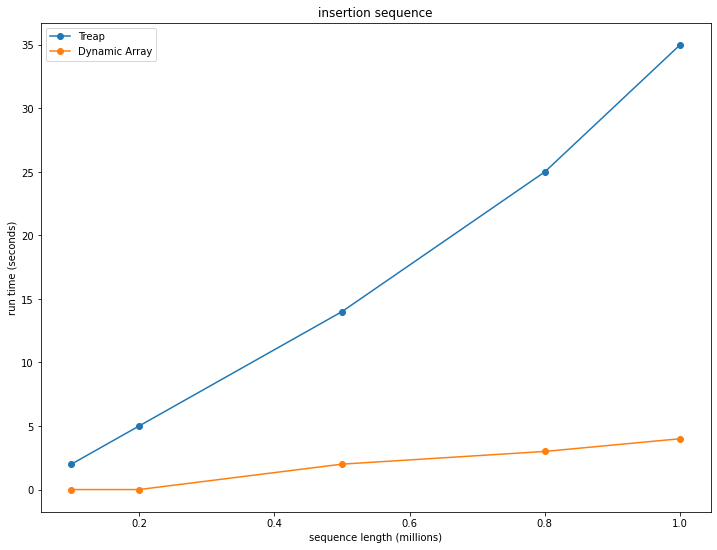

In [15]:
x = (0.1, 0.2, 0.5, 0.8, 1)
plt.figure(figsize=(12,9))
plt.plot(x, t_insertions,  marker='o', label='Treap')
plt.plot(x, da_insertions, marker='o', label='Dynamic Array')
plt.title('insertion sequence')
plt.ylabel('run time (seconds)')
plt.xlabel('sequence length (millions)')
plt.legend()
plt.show()

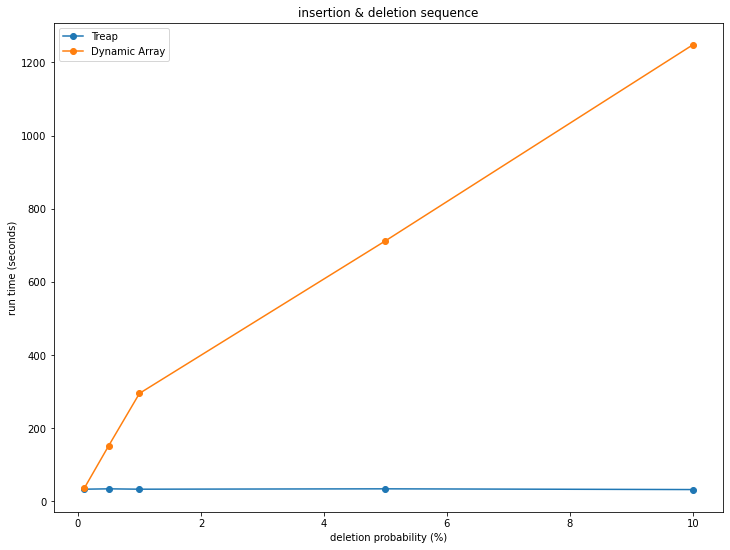

In [16]:
x = (0.1, 0.5, 1, 5, 10)
plt.figure(figsize=(12,9))
plt.plot(x, t_deletions,  marker='o', label='Treap')
plt.plot(x, da_deletions, marker='o', label='Dynamic Array')
plt.title('insertion & deletion sequence')
plt.ylabel('run time (seconds)')
plt.xlabel('deletion probability (%)')
plt.legend()
plt.show()

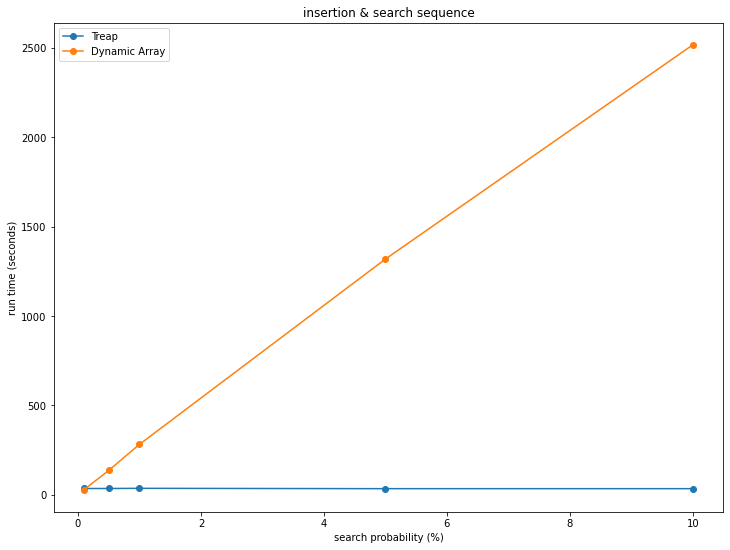

In [17]:
x = (0.1, 0.5, 1, 5, 10)
plt.figure(figsize=(12,9))
plt.plot(x, t_searches,  marker='o', label='Treap')
plt.plot(x, da_searches, marker='o', label='Dynamic Array')
plt.title('insertion & search sequence')
plt.ylabel('run time (seconds)')
plt.xlabel('search probability (%)')
plt.legend()
plt.show()

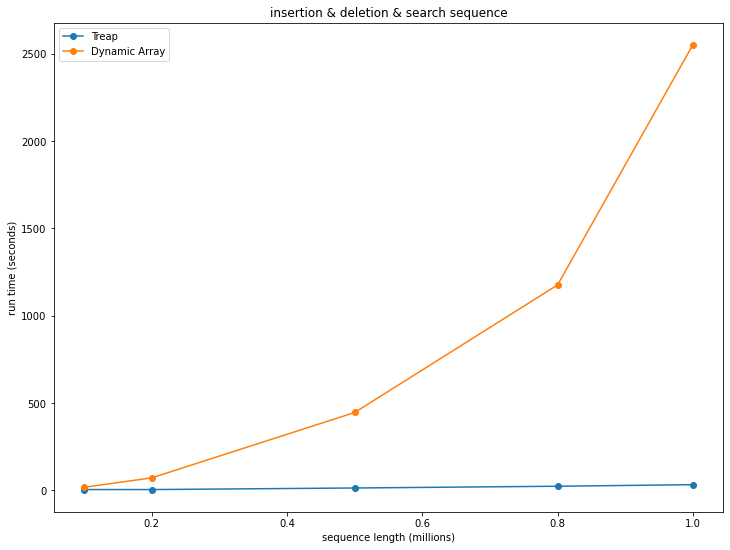

In [18]:
x = (0.1, 0.2, 0.5, 0.8, 1)
plt.figure(figsize=(12,9))
plt.plot(x, t_mixes,  marker='o', label='Treap')
plt.plot(x, da_mixes, marker='o', label='Dynamic Array')
plt.title('insertion & deletion & search sequence')
plt.ylabel('run time (seconds)')
plt.xlabel('sequence length (millions)')
plt.legend()
plt.show()

#### Insertion Sequences

In [20]:
DF.from_records(data = (t_insertions, da_insertions),
                columns = ('0.1M', '0.2M', '0.5M', '0.8M', '1M'),
                index   = ('Treap', 'Dynamic Array'))

,0.1M,0.2M,0.5M,0.8M,1M
Treap,2,5,14,25,35
Dynamic Array,0,0,2,3,4


#### Insertion & Deletion Sequences

In [21]:
DF.from_records(data = (t_deletions, da_deletions),
                columns = ('0.1%', '0.5%', '1%', '5%', '10%'),
                index   = ('Treap', 'Dynamic Array'))

,0.1%,0.5%,1%,5%,10%
Treap,33,34,33,34,32
Dynamic Array,35,152,295,712,1248


#### Insertion & Search Sequences

In [22]:
DF.from_records(data = (t_searches, da_searches),
                columns = ('0.1%', '0.5%', '1%', '5%', '10%'),
                index   = ('Treap', 'Dynamic Array'))

,0.1%,0.5%,1%,5%,10%
Treap,34,34,35,33,33
Dynamic Array,28,135,281,1318,2517


#### Insertion & Deletion & Search Sequences

In [24]:
DF.from_records(data = (t_mixes, da_mixes),
                columns = ('0.1M', '0.2M', '0.5M', '0.8M', '1M'),
                index   = ('Treap', 'Dynamic Array'))

,0.1M,0.2M,0.5M,0.8M,1M
Treap,5,5,14,24,33
Dynamic Array,18,72,446,1176,2550
